# Plotting elevation data with different libraries

The aim of this Notebook is to illustrate different ways of visualizing the same kind of data by using various libraries and python-packages already integrated into Noteable. For the majority of this Notebook, Ordonance Survey terrain 50 Digital Terrain Model (DTM) data of the Lake District was acquired from DigiMap. The data is made up of a raster grid of heighted points with regular 50 metre spacing

In [1]:
# Once ridge_map and earthpy are in the live GeoNotebook, delete this cell
!pip install ridge_map --quiet
!pip install earthpy --quiet

In [2]:
# Import all the necessary libraries

## General python libraries for data analysis and visualization
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests, zipfile, io, os
from osgeo import gdal, osr

## Geospatial python libraries
import geopandas as gpd

import rasterio as rio
from rasterio.plot import show

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

from ridge_map import RidgeMap

from skimage import measure

## Hide warning messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set up function to customize the chosen matplotlib colormap

def truncate_colormap(cmap, minval, maxval, n=100):
    cmapsample = cmap(np.linspace(minval, maxval, n)) #Sample the original colormap at n points between minval and maxval
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
           'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmapsample)  #Create new colormap using the range that was sampled in cmapsample
    return new_cmap #Return new colormap that can be called upon with get_cmap

# See: https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib

In [4]:
# Create the colormap for the contourplots

from matplotlib.colors import LinearSegmentedColormap
cMap = []

custom = LinearSegmentedColormap.from_list(["lightblue", "darkgreen", "green", "mediumseagreen", 
                          "lightgreen", "gold", "goldenrod", "darkgoldenrod", "brown", "black"], ["lightblue", "darkgreen", "green", "mediumseagreen", 
                          "lightgreen", "gold", "goldenrod", "darkgoldenrod", "brown", "black"], N=10)
m = matplotlib.cm.ScalarMappable(cmap=custom)




## Ridge_map
Ridge_map is a python library aimed at creating ridge maps of elevaton data which comes from NASA's Shuttle Radar Topography Mission (SRTM), high resolution topographic data collected in 2000 and released in 2015. SRTM data are sampled at a resolution of 1 arc-second (about 30 meters). SRTM data is provided to ridge_map via the python package SRTM.py, which is licensed under the Apache License, Version 2.0. **insert apache license link**

The following section illustrates how to create ridge maps of Great Britain and the Lake District. Of course, you can select a bounding box of your area of interest, for example by obtaining the points of a polygon, specified by you, using http://bboxfinder.com/. Once you load in the elevation data from SRTM, you can preprocess it to automatically detect lakes, rivers, and oceans, and scale the elevations.

### Great Britain
Great Britain was chosen to show the large scale maps this library can achieve in comparison to others where the data is split into numerous tiles. Substantially larger polygons can be selected, although SRTM is not available for latitudes outside of the range N 60° - S 60°.

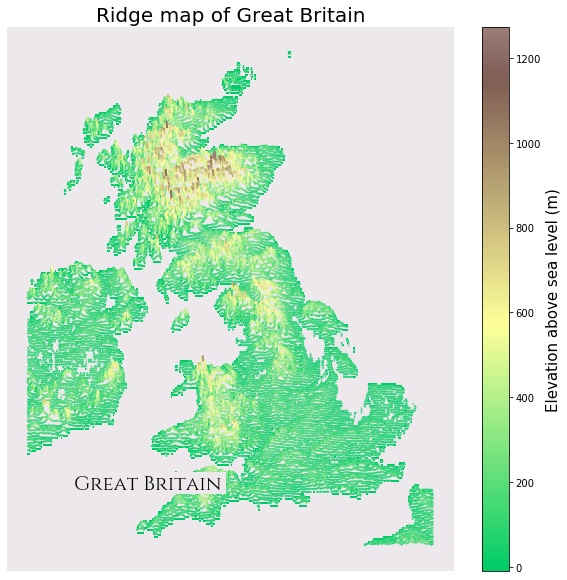

In [5]:
# Identify the points of the polygon of Great Britain from http://bboxfinder.com/
polygon = (-8.657227,49.761777,2.241211,59.625348)

# Get the elevation values for each data point within the polygon
rm = RidgeMap(polygon)
values = rm.get_elevation_data(num_lines=220, elevation_pts=550)

# Specify the colormap segment for this example - range from deep green to darkbrown
cmap = plt.get_cmap('terrain') # Colormap ranging darkblue-green-yellow-brown-white
new_cmap = truncate_colormap(cmap, 0.25, 0.8) # Cutting out darkblue and white ends

# Plot the ridge map
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
rm.plot_map(values=rm.preprocess(values=values, lake_flatness=4, water_ntile=30, vertical_ratio=70),
            ax=ax,
            label='Great Britain', #Label the map with the name of the area
            label_x=0.15, #Set location of label
            label_size=20, #Set size of the label
            linewidth=2, #Set the thickness of the lines
            line_color = plt.get_cmap(new_cmap), #Set colormap of the lines
            kind='elevation')

# Add colorbar and customize the map
norm = matplotlib.colors.Normalize(vmin=np.nanmin(values), vmax=np.nanmax(values))
sm = plt.cm.ScalarMappable(norm = norm, cmap=new_cmap)
plt.colorbar(sm).set_label(label = 'Elevation above sea level (m)', size=15)

plt.title("Ridge map of Great Britain", size=20)

# Save the figure
plt.savefig("./data/GB_ridgemap.png")

### Lake District
For the rest of this Notebook, the Lake District region will be used to showcase different possibilites of plotting elevation data due to the data format and size needed for the libraries other than ridge_map. The following ridge map is of the Lake District so that the image can be reasonably compared to the maps plotted using other libraries.

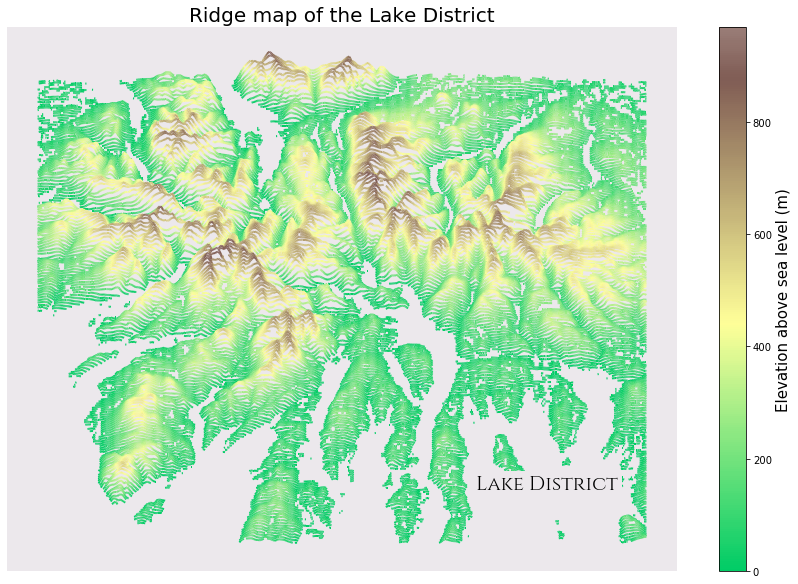

In [6]:
#Set up the figure
fig, ax = plt.subplots(figsize=(15, 10))

# Identify the points of the polygon of the Lake District
polygon = (-3.433415,54.197751,-2.678271,54.648501)

# Get the elevation values for each data point within the polygon
rm = RidgeMap(polygon)
values = rm.get_elevation_data(num_lines=220, elevation_pts=550)

# Plot the ridge map
rm.plot_map(values=rm.preprocess(values=values, lake_flatness=4, water_ntile=25, vertical_ratio=100),
            label='Lake District', #Labelling the map with the name of the area
            label_x=0.7, #Set location of label
            label_size=20, #Set size of the label
            linewidth=2, #Set the thickness of the lines
            line_color = plt.get_cmap(new_cmap), #Set colormap of the lines
            kind='elevation', ax=ax)

# Add colorbar and customize the map
norm = matplotlib.colors.Normalize(vmin=np.nanmin(values), vmax=np.nanmax(values))
sm = plt.cm.ScalarMappable(norm = norm, cmap=new_cmap)
plt.colorbar(sm).set_label(label = 'Elevation above sea level (m)', size=15)

plt.title("Ridge map of the Lake District", size=20)

# Save the figure
plt.savefig("./data/LD_ridgemap.png")

## Pre-processing the OS terrain 50 DTM data of the Lake District 
The data from Digimap can be downloaded in a zip file containing all the necessary files and documentation. Before it can be plotted, it first needs to be loaded into the Notebook and preprocessed. The unzipped folder reveals that the separate ascii files are split into folders named after the National Grid tiles they belong to. The files ending with ".asc" also need to be converted to ".tif" images and merged into one large ".tif" image to make plotting it easier.

In [7]:
# ONLY RUN ONCE
## Extract the folders from the zip file into a directory "./data/LakeDistrict"

z = zipfile.ZipFile('./Lake_District.zip')
z.extractall(path="./data/LakeDistrict")

In [8]:
# ONLY RUN ONCE
## Convert each ".asc" file into a geotiff files

drv = gdal.GetDriverByName('GTiff')
for item in os.listdir("./data/LakeDistrict/terrain-50-dtm_3563996"):
    for i in os.listdir("./data/LakeDistrict/terrain-50-dtm_3563996/" + item):
        if i.endswith(".asc"):
            ds_in = gdal.Open('./data/LakeDistrict/terrain-50-dtm_3563996/' + item + "/" + i )
            i = i.strip('.asc')
            ds_out = drv.CreateCopy(i +'.tif', ds_in)
            srs = osr.SpatialReference()
            srs.ImportFromEPSG(7405)
            ds_out.SetProjection(srs.ExportToWkt())
            ds_in = None
            ds_out = None

In [9]:
# ONLY RUN ONCE
## Combine all the individual geotiff files into one called "merged.tif"
!gdal_merge.py  -o merged.tif NY10.tif NY11.tif NY12.tif NY20.tif NY21.tif NY22.tif NY30.tif NY31.tif NY32.tif NY40.tif NY41.tif NY42.tif NY50.tif NY51.tif NY52.tif SD18.tif SD19.tif SD28.tif SD29.tif SD38.tif SD39.tif SD48.tif SD49.tif SD58.tif SD59.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [10]:
# Load in the data using rasterio

src = rio.open("merged.tif")
elevation = src.read(1)

## Matplotlib
This section illustrates different ways of plotting the Lake District data using the matplotlib library. The first example uses the methods *contour* and *contourf*, whereas the second uses *plt.imshow*. The data was loaded in using the library rasterio in both cases.

In [11]:
# Define a function to customize the plots with axis labels and titles to avoid repeating the same lines of code

def LDplot(title, axes, end):
    for i in range(0,end):
        axes[i].set_title(title[i], size=20)
        axes[i].set_xticks([310000, 320000, 330000, 340000, 350000, 360000])
        axes[i].set_xticklabels(["310km", "320km", "330km", "340km", "350km", "360km"])
        axes[i].set_yticks([480000, 490000, 500000, 510000, 520000, 530000])
        axes[i].set_yticklabels(["480km", "490km", "500km", "510km", "520km", "530km"])
        axes[i].set_xlabel("False Eastings")
        axes[i].set_ylabel("False Northings")


### Using the contour and contourf methods and numpy meshgrids

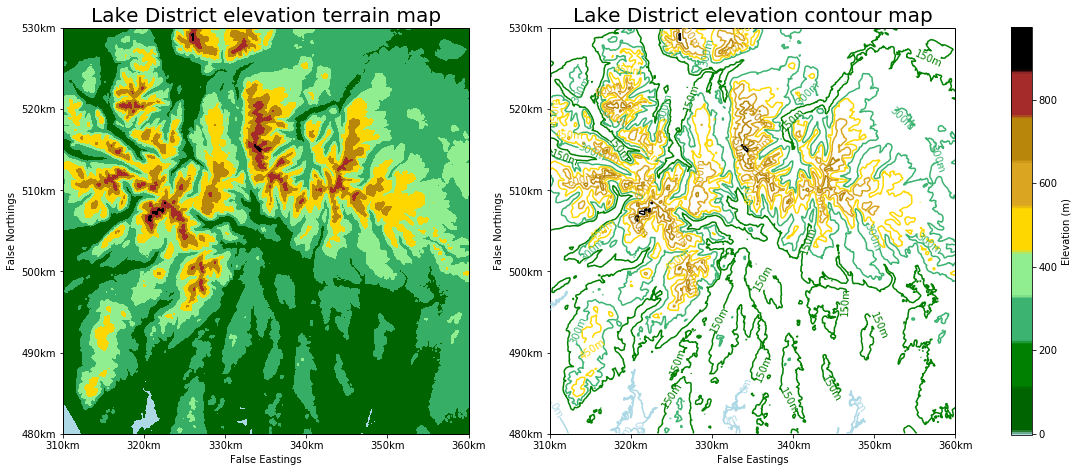

In [12]:
# Set figure size and axes
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 1, projection=ccrs.OSGB())
ax2= fig.add_subplot(1, 2, 2, projection=ccrs.OSGB())

# Create meshgrid with numpy
x = np.arange(310000, 360000, 50)
y = np.arange(480050, 530050, 50)
y = np.flip(y)
xx, yy = np.meshgrid(x, y, sparse=True)
'''Note: 
    I used meshgrid to be able to add axes ticklabels
    Can also use instead of meshgrid, but LDplot(title, axes, 2) has to be commented out first:
    ax.contour(src.read(1), cmap = customcmap, 
               title = "Lake District elevation contour map", 
               origin ="upper")'''

# Specify the colormap segment for this example
customcmap = truncate_colormap(custom, 0.091, 1)

# Create terrain and contourmaps using contour and contourf
norm = matplotlib.colors.Normalize(vmin=np.nanmin(elevation),
                                   vmax=np.nanmax(elevation))

ax.contourf(x, y, src.read(1), cmap = customcmap,
            title = "Lake District elevation contour map", norm=norm  )
CS = ax2.contour(x, y, src.read(1), cmap = customcmap,
                 title = "Lake District elevation contour map", norm=norm )
ax2.clabel(CS, inline=1, fontsize=10, fmt='%1.fm')

# Add colorbar and customize the map
sm = plt.cm.ScalarMappable(norm = norm, cmap=customcmap)
plt.colorbar(sm, ax=[ax, ax2], shrink = 0.75, label="Elevation (m)")

title =["Lake District elevation terrain map", "Lake District elevation contour map"]
axes = [ax, ax2]
LDplot(title, axes, 2)
plt.show()

# Save figure
fig.savefig("LDmatplotlibcontour")

### Using the imshow method

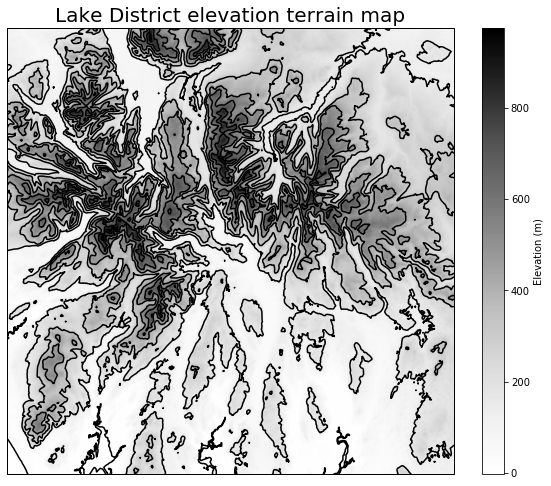

In [13]:
# Set figure size and axes
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.OSGB())

# Create terrainmap using imshow
plt.imshow(src.read(1), cmap="Greys", norm=norm)

# Add colorbar and customize the map
norm = matplotlib.colors.Normalize(vmin=np.nanmin(elevation), 
                                   vmax=np.nanmax(elevation))
sm = plt.cm.ScalarMappable(norm = norm, cmap="Greys")
plt.colorbar(sm, ax=ax, shrink=0.82, label="Elevation (m)")

ax.set_title("Lake District elevation terrain map", size=20)

# Create contours using skimage
interval = [0,150,300,450,600,750,900]
for height in interval:
    contours = measure.find_contours(src.read(1), height)
    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, c="black")

plt.show()

# Save figure
fig.savefig("LDimshowblakandwhite")

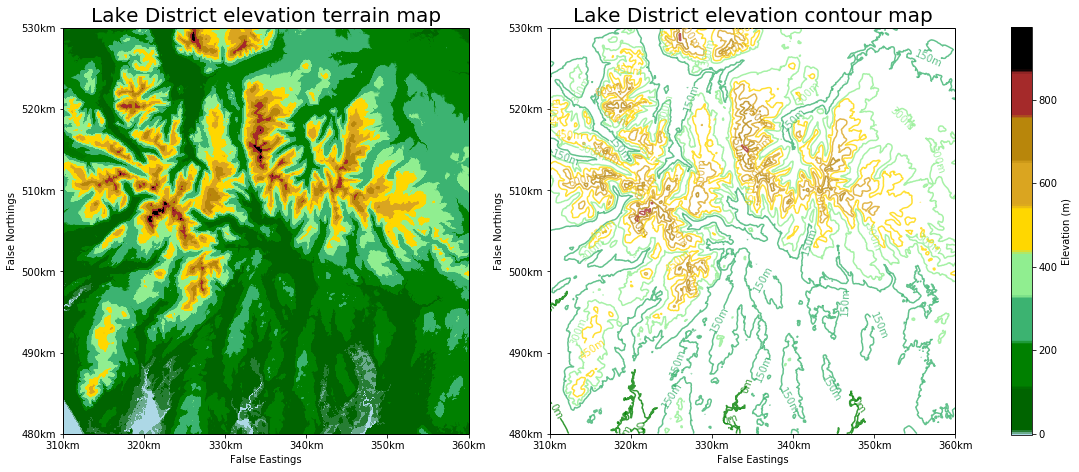

In [14]:
# Set figure size and axes
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 1, projection=ccrs.OSGB())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.OSGB())

# Create terrain and contourmap using rasterio
show(src, ax=ax, cmap = customcmap, origin='upper',
     title = "Lake District elevation terrain map",
     transform = src.transform)
show(src, ax=ax2, cmap = customcmap,
     title = "Lake District elevation contour map",
     contour=True, 
     contour_label_kws = {'fmt':'%1.fm'},
     transform = src.transform)

# Add a colorbar and customize map
norm = matplotlib.colors.Normalize(vmin=np.nanmin(elevation), vmax=np.nanmax(elevation))
sm = plt.cm.ScalarMappable(norm = norm, cmap=customcmap)
plt.colorbar(sm, ax=[ax, ax2], shrink = 0.75, label="Elevation (m)")

title =["Lake District elevation terrain map", "Lake District elevation contour map"]
axes = [ax, ax2]
LDplot(title, axes, 2)

plt.show()

# Save figure
fig.savefig("LDrasterio") 

## Geopandas
**Question at anyone reviewing this:** I could use the contour shapefiles version of the digimap data of this... new notebook or still this one?

## EarthPy
This section illustrates different ways of plotting the Lake District data using the EarthPy library. The main difference to the previous methods of visualizing the data is the EarthPy's hillshade function. This enables you to overlay raster dat on top of a hillshade. A hillshade is a 3D representation of a surface and are generally rendered in greyscale. The darker and lighter colors represent the shadows and highlights that you would visually expect to see in a terrain model. Hillshades are often used as an underlay in a map to make the data appear more 3D and thus visually more interesting.

### Using EarthPy without hillshade

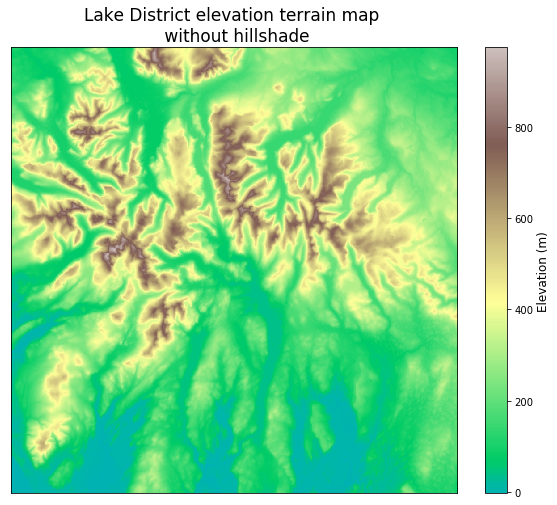

In [15]:
# Set figure size and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Specify the colormap segment for this example
cmap = plt.get_cmap('terrain')
new_cmap = truncate_colormap(cmap, 0.2, 0.9)

# Create terrainmap without hillshade using EarthPy
norm = matplotlib.colors.Normalize(vmin=elevation.min(), 
                                   vmax=elevation.max())
ep.plot_bands(elevation, cmap=new_cmap, ax=ax,
    cbar=False, norm=norm)
sm = plt.cm.ScalarMappable(norm = norm, cmap=new_cmap)
plt.colorbar(sm, ax=ax, shrink=0.82).set_label(label = 'Elevation (m)', size=12)

ax.set_title("Lake District elevation terrain map \n without hillshade", size=17)

# Save figure
plt.savefig("LDearthpywithouthillshade")

### Hillshade function - changing the azimuth
The azimuth argument within hillshade() sets the location of the Sun with respect to the map. Its values range from 0° to 360°. If it is set to be 0°, the Sun is directly to the North of the map, and moves in a clockwise direction as you increase the azimuthal angle. The default azimuth is 30°.

**Question at anyone reviewing this:** Should this be in a different notebook dedicated to EarthPy?

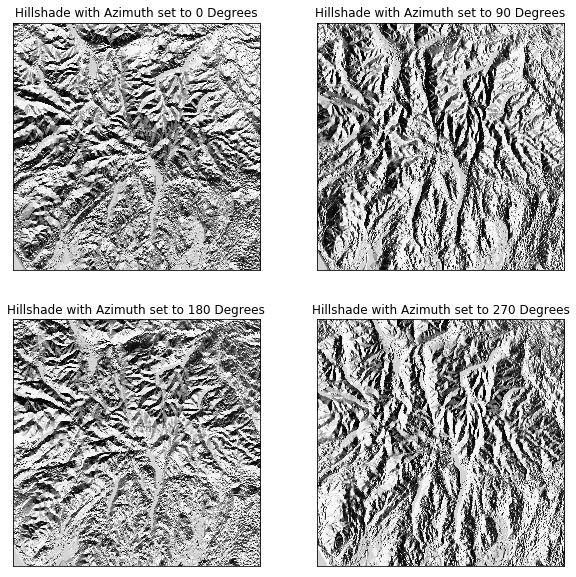

In [16]:
# Set figure size and axes
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# Create hillshade maps with azimuthal angles of 0°, 90°, 180° and 270°
angle = [0, 90, 180, 270]
axes =[ax, ax2, ax3, ax4]
for i in range(0,4):
    # Change the azimuth of the hillshade layer
    hillshade_azimuth = es.hillshade(elevation, azimuth=angle[i])
    # Plot the hillshade layer with the modified azimuth
    ep.plot_bands(hillshade_azimuth, ax=axes[i], 
                  cbar=False, title="Hillshade with Azimuth set to " + str(angle[i])+ " Degrees")

# Save figure
fig.savefig("LDazimuthhillshades")

### Hillshade function - changing the angle altitude of the sun
The altitude parameter determines the inclination angle of the sunlight with respect to the map. Its values range from 0° to 90°. 90 represents the sun shining from directly above the scene. The default value for altitude is 30°.

**Question at anyone reviewing this:** Should this be in a different notebook dedicated to EarthPy?

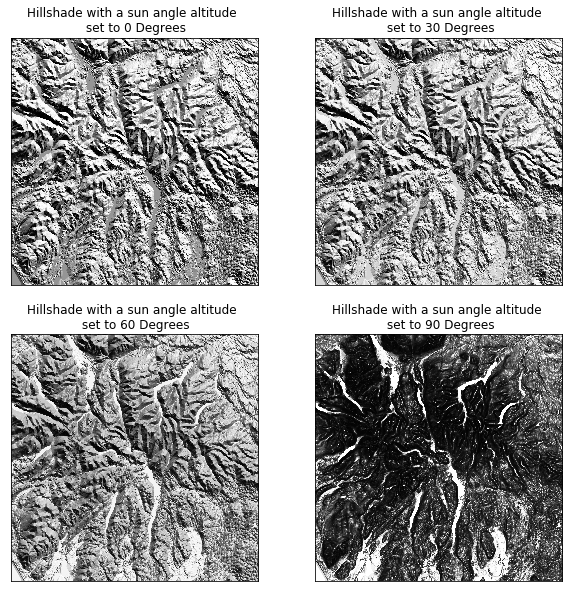

In [17]:
# Set figure size and axes
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# Create hillshade maps with inclination angles of 0°, 90°, 180° and 270°
altitude = [0, 30, 60, 90]
axes =[ax, ax2, ax3, ax4]
for i in range(0,4):
    # Change the azimuth of the hillshade layer
    hillshade_altitude = es.hillshade(elevation, altitude=altitude[i])
    # Plot the hillshade layer with the modified azimuth
    ep.plot_bands(hillshade_altitude, ax=axes[i], 
                  cbar=False, title="Hillshade with a sun angle altitude \n set to " + str(altitude[i])+ " Degrees")

# Save figure
fig.savefig("LDalitudehillshades")

### Using Earthpy with hillshade

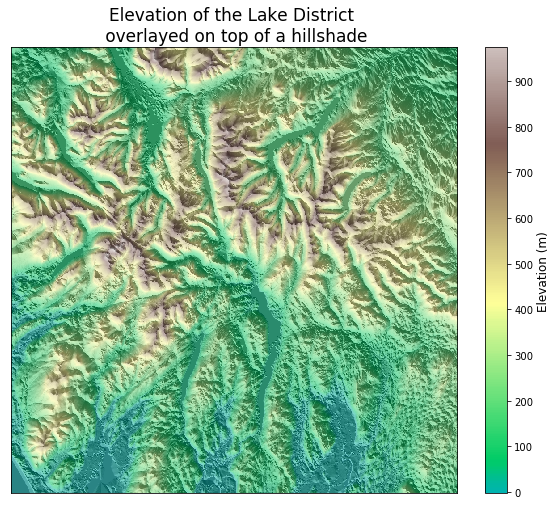

In [18]:
# Set figure size and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Create terrainmap
ep.plot_bands( elevation, cbar=False,
    ax=ax, cmap=new_cmap)

# Create hillshade
hillshade = es.hillshade(elevation)
ax.imshow(hillshade, cmap="Greys", alpha=0.5)

# Add colorbar and customize the map
plt.colorbar(sm, ax=ax, ticks=np.arange(-100, 1000, 100), shrink=0.82).set_label(label = 'Elevation (m)', size=12)
ax.set_title("Elevation of the Lake District \n overlayed on top of a hillshade", size=17)


# Save figure
fig.savefig("hillshade")